# Extract data from output files

### Code to extract timing information from output files of Lbann code
March 9, 2020

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import subprocess as sp
import os
import glob
import itertools

from ipywidgets import interact, interact_manual,fixed, SelectMultiple, RadioButtons

In [38]:
def f_extract_info(fname):
    '''
    Module to extract information from out.log files of Lbann training
    Reads in file name
    '''
    strg_lst=['objective','d_real','d_fake','gen','run time','mini-batch']
    keys=['training_'+strg for strg in strg_lst]
    dict1={}
    for category in ['training','validation']:
        for strg in strg_lst:
            key=category+'_'+strg
            cmd='grep "{0}" {1} | grep "{2}"'.format(category,fname,strg)
    #         print(cmd)
            op1=sp.check_output(cmd,shell=True).decode('utf-8').split('\n')
            obj=np.array([strg.split(':')[-1] for strg in op1 if strg])
            dict1[key]=obj
    
    df=pd.DataFrame([])
    key_lst=['training_objective', 'training_d_real', 'training_d_fake', 'training_gen', 'validation_objective', 'validation_d_real', 'validation_d_fake', 'validation_gen']
    col_list=['train_obj','train_dreal','train_dfake','train_gen','val_obj','val_dreal','val_dfake','val_gen']
    for col,key in zip(col_list,key_lst):
        df[col]=dict1[key].astype(np.float)

    ### Need to remove the trailing 's' in the timings
    for col,key in zip(['train_time','val_time'],['training_run time','validation_run time']):
        df[col]=np.array([i[:-1] for i in dict1[key]]).astype(np.float)

    for col,key in zip(['train_batch_stats','val_batch_stats'],['training_mini-batch','validation_mini-batch']):
        df[col]=dict1[key]
        
    return df


def f_get_summary_of_runs(df_list):
    '''
    Module to collect info from dataframes for a series of runs and add it to a new dataframe
    Input -> list of DataFrames
    output-> DataFrame
    '''
    
    col_list=['train_obj', 'train_dreal', 'train_dfake', 'train_gen', 'val_obj', 'val_dreal', 'val_dfake', 'val_gen', 'train_time', 'val_time']
    df_summary=pd.DataFrame(columns=col_list)
    
    for df in df_list: 
        mean_dict={}
        for col in col_list:
            N=df.shape[0]  ### Number of epochs
            ### Create dictionary of tuples of type (mean,err) for each quantity
            mean_dict[col]=(df[col].mean(),df[col].std()/np.sqrt(N))
        df_summary=df_summary.append(mean_dict,ignore_index=True)

    return df_summary


### Extract data

In [40]:
# fname='/global/cfs/cdirs/m3363/vayyar/cosmogan_data/results_data/20200331_131011_exagan/slurm-513349.out'
# df=f_extract_info(fname)
### Collecting a group of results
main_dir='/global/cfs/cdirs/m3363/vayyar/cosmogan_data/results_data/tests_varying_flip_ratio/'
f_list=['20200401_125919_exagan_0.1_1/slurm-516303.out','20200401_130321_exagan_0.1_4/slurm-516318.out',
        '20200401_130907_exagan_0.3_1/slurm-516339.out','20200401_130646_exagan_0.3_4/slurm-516342.out']

df_list=[f_extract_info(main_dir+fname) for fname in f_list]


### Get summary of quantities for each dataframe
df_summary=f_get_summary_of_runs(df_list)



In [43]:
df_summary

,train_obj,train_dreal,train_dfake,train_gen,val_obj,val_dreal,val_dfake,val_gen,train_time,val_time
0,"(2.92612205, 0.030310473656939563)","(0.3505281600000001, 0.0023375190299006633)","(0.35120343, 0.006467810282559424)","(2.22439015, 0.022001397123234213)","(1.3845953549999999, 0.04299508133172798)","(0.36446363000000004, 0.004294195526032143)","(0.46873695, 0.02514815688780803)","(0.5513951349999999, 0.031145561963702915)","(9.4327715, 0.21051936009656233)","(0.8113460849999999, 0.020126423086964967)"
1,"(2.8962641, 0.024003410896040814)","(0.34910026, 0.00202469070457886)","(0.358835445, 0.006708969076911866)","(2.18832885, 0.016164129045198712)","(2.21109388, 0.08711575219927625)","(0.3610697949999999, 0.0029690034165866823)","(0.48099901500000003, 0.02214833117263323)","(1.36902521, 0.08750296768622112)","(9.0975297, 0.20106197487298208)","(0.892485375, 0.01931883453756257)"
2,"(2.32809635, 0.014591186313699546)","(0.6439099899999999, 0.0022701613298656965)","(0.6616599750000001, 0.0054673018782771575)","(1.022526385, 0.00738071396257303)","(2.28380535, 0.03965001703941015)","(0.6694321199999999, 0.004392478617632623)","(0.93542344, 0.03491027665813204)","(0.67894978, 0.010698162455197481)","(8.75411615, 0.24603015621210367)","(0.871237495, 0.051347584093434345)"
3,"(2.2693362500000003, 0.01186580792321114)","(0.64754971, 0.0021446108449461885)","(0.6624317250000001, 0.006421980807676688)","(0.9593551600000001, 0.004288920345263136)","(2.3896832, 0.0453172715165235)","(0.6771146950000001, 0.004817736000150445)","(0.9179258950000001, 0.03992031795781674)","(0.79464279, 0.022570061983937337)","(8.9797505, 0.18428219000044618)","(0.874908425, 0.025325709794173888)"


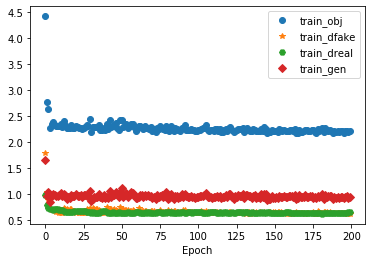

In [41]:
def f_plot(df,col_list=['train_obj']):
    '''
    Plot multiple columns of the dataframe
    '''
    plt.figure()
    
    marker_lst=('o','*','H','D','.','x')
    marker=itertools.cycle(marker_lst)
    for col in col_list: plt.plot(df[col],linestyle='',marker=next(marker),label=col)
    plt.legend()
    plt.xlabel('Epoch')

f_plot(df,col_list=['train_obj','train_dfake','train_dreal','train_gen'])
# plt.savefig('fig2.png')

In [12]:
df=df_list[0]
col_list=['train_obj', 'train_dreal', 'train_dfake', 'train_gen', 'val_obj',
       'val_dreal', 'val_dfake', 'val_gen', 'train_time', 'val_time']
interact_manual(f_plot,col_list=SelectMultiple(options=col_list),df=fixed(df))


interactive(children=(SelectMultiple(description='col_list', options=('train_obj', 'train_dreal', 'train_dfake…

<function __main__.f_plot(df, col_list=['train_obj'])>

In [45]:
df=df_list[3]
col_list=['train_obj', 'train_dreal', 'train_dfake', 'train_gen', 'val_obj',
       'val_dreal', 'val_dfake', 'val_gen', 'train_time', 'val_time']
interact_manual(f_plot,col_list=SelectMultiple(options=col_list),df=fixed(df))


interactive(children=(SelectMultiple(description='col_list', options=('train_obj', 'train_dreal', 'train_dfake…

<function __main__.f_plot(df, col_list=['train_obj'])>

In [44]:
col_list=['train_obj', 'train_dreal', 'train_dfake', 'train_gen', 'val_obj',
       'val_dreal', 'val_dfake', 'val_gen', 'train_time', 'val_time']
# interact_manual(f_plot,col_list=SelectMultiple(options=col_list),df=RadioButtons(options=(df_list)))
# interact_manual(f_plot,col_list=SelectMultiple(options=col_list),df=df_list[0])



In [41]:
df_list[0]

,train_obj,train_dreal,train_dfake,train_gen,val_obj,val_dreal,val_dfake,val_gen,train_time,val_time,train_batch_stats,val_batch_stats
0,8.29299,0.734602,1.576500,5.98188,3.548870,1.061340,2.118400,0.369132,12.39530,0.930877,"0.0514474s mean, 3.77537s max, 0.0292944s min...","0.0344169s mean, 0.171807s max, 0.012867s min..."
1,4.15511,0.491042,0.564253,3.09982,1.897940,0.589476,0.871481,0.436979,8.58775,0.770991,"0.0355958s mean, 0.112133s max, 0.01706s min,...","0.0284823s mean, 0.0987215s max, 0.00834055s ..."
2,3.54950,0.445171,0.448888,2.65544,1.513070,0.431094,0.691864,0.390107,8.54723,0.704984,"0.0354157s mean, 0.119187s max, 0.0169134s mi...","0.0260352s mean, 0.0425187s max, 0.0143342s m..."
3,3.43533,0.405864,0.404803,2.62466,1.638860,0.462821,0.839427,0.336614,9.00290,0.765598,"0.0373298s mean, 0.299047s max, 0.0165659s mi...","0.0282765s mean, 0.0508229s max, 0.0136443s m..."
4,3.19828,0.398862,0.372190,2.42722,1.384890,0.435223,0.363098,0.586566,8.30459,0.699121,"0.0344113s mean, 0.0493175s max, 0.0163551s m...","0.0258174s mean, 0.0362386s max, 0.0138811s m..."
5,3.37565,0.400286,0.412445,2.56292,1.641880,0.434495,0.763538,0.443846,8.44567,0.735817,"0.0349967s mean, 0.0718791s max, 0.0168285s m...","0.0271755s mean, 0.0488194s max, 0.0136544s m..."
6,4.08059,0.403729,0.516949,3.15991,1.127210,0.382486,0.420803,0.323919,8.39973,0.738227,"0.034793s mean, 0.0611393s max, 0.0170274s mi...","0.0272769s mean, 0.0433156s max, 0.0158883s m..."
7,3.19884,0.376537,0.388886,2.43342,1.055440,0.344678,0.357320,0.353442,8.38637,1.003330,"0.0347436s mean, 0.177438s max, 0.0166116s mi...","0.0370796s mean, 0.293308s max, 0.00822506s m..."
8,3.02927,0.379226,0.363558,2.28649,1.003930,0.362860,0.332816,0.308254,8.44013,0.765260,"0.0349675s mean, 0.062351s max, 0.0165703s mi...","0.0282727s mean, 0.0452296s max, 0.0133072s m..."
9,2.99633,0.373944,0.358442,2.26395,1.148550,0.433494,0.369769,0.345284,8.29442,0.756843,"0.0343623s mean, 0.0666908s max, 0.0168557s m...","0.0279651s mean, 0.0487117s max, 0.0140222s m..."


In [43]:
df=df_list[0]
df[df.val_gen>1.0]

,train_obj,train_dreal,train_dfake,train_gen,val_obj,val_dreal,val_dfake,val_gen,train_time,val_time,train_batch_stats,val_batch_stats
49,2.86236,0.353308,0.335350,2.17370,2.17569,0.364809,0.515109,1.29577,8.37151,0.726926,"0.0346927s mean, 0.0570739s max, 0.0169118s m...","0.0268691s mean, 0.0346191s max, 0.0141335s m..."
78,2.85440,0.356386,0.347972,2.15004,1.90488,0.365027,0.450135,1.08972,14.75360,0.746932,"0.0612776s mean, 3.58531s max, 0.0169188s min...","0.0276119s mean, 0.0361814s max, 0.0140201s m..."
97,2.82573,0.340526,0.324235,2.16097,2.02484,0.387202,0.381050,1.25659,16.82310,0.780121,"0.0699008s mean, 5.0552s max, 0.017083s min, ...","0.0288272s mean, 0.0346576s max, 0.0185244s m..."
98,2.82315,0.342679,0.326315,2.15415,1.76364,0.374070,0.342678,1.04689,17.80070,2.908790,"0.0739815s mean, 5.67842s max, 0.0166164s min...","0.107661s mean, 2.17489s max, 0.0149655s min,..."
103,3.20617,0.345831,0.398641,2.46170,5.20909,0.344568,1.844950,3.01958,8.48217,0.748795,"0.0351342s mean, 0.0625273s max, 0.0168107s m...","0.0276685s mean, 0.0424144s max, 0.0137398s m..."
104,3.23926,0.325869,0.364990,2.54840,2.44878,0.329676,0.335225,1.78388,8.34925,0.744218,"0.0345753s mean, 0.0539453s max, 0.0168988s m...","0.0274897s mean, 0.0412984s max, 0.0140094s m..."
105,3.01932,0.325972,0.346997,2.34635,2.13538,0.365717,0.404098,1.36557,8.24749,0.743991,"0.0341711s mean, 0.0798778s max, 0.0166495s m...","0.027487s mean, 0.0455017s max, 0.00991712s m..."
106,2.92898,0.339205,0.345565,2.24421,2.05831,0.320226,0.628483,1.10960,8.43623,0.763672,"0.0349597s mean, 0.0522192s max, 0.0167664s m...","0.0282132s mean, 0.0383313s max, 0.0147019s m..."
107,2.81655,0.344699,0.338195,2.13366,2.08411,0.361528,0.337157,1.38543,8.36617,0.763379,"0.034657s mean, 0.0574597s max, 0.0165236s mi...","0.0278351s mean, 0.0572661s max, 0.00827422s ..."
108,2.86099,0.337842,0.335703,2.18745,3.45479,0.374903,0.458706,2.62119,8.41171,0.737712,"0.0348594s mean, 0.0605832s max, 0.0164335s m...","0.0272452s mean, 0.0366323s max, 0.0140734s m..."


### To add : 
- Widget for choosing dataframe
- Summary info (mean,err) for each quantity for a single Dataframe

In [46]:
16384/(128*128)

1.0